In [1]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
from Variables import *
from LoadFunctions import *
from ThreeDWindRadarFunctions import *
from MatchFunctions import *
from OtherUsefulFunctions import *
from Paths import *

In [3]:
from scipy.constants import golden 
matplotlib.rcParams['figure.figsize'] = (golden * 10, 10)
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
fontsize1 = 22
matplotlib.rcParams.update({'font.size': fontsize1})

# Scatter plots

In [4]:
startDate = dt.datetime(2020,6,19)
endDate = dt.datetime(2020,8,18)
dateList = produceDateList(startDate,endDate)

In [5]:
xA = defaultdict(list);yA = defaultdict(list);zNoise = defaultdict(list);zSig = defaultdict(list);

for date in dateList:
    mode = 'high'
    # Load 
    folder_radar, filepaths_radar,filenames_radar, date_radar, date_radardt,radarNoFile = loadRadar(date, path_dat, verbose=False)
    folder_lidar, filepaths_lidar, filenames_lidar, date_lidar,date_lidardt, _,_,_,lidarNoFile = loadLidar(date, path_lidar,optionZip=False, verbose=False)

    # Match
    if (radarNoFile is False):
        lidarStart, lidarEnd, indiceMissing = lidarStartEnd(date, filepaths_lidar, reCreate=False, verbose=False)
        radarStart, radarEnd = radarStartEnd(date, filepaths_radar, reCreate=False, verbose=False) #m14 !!
        Data = retrieveLidarRadialSpeed(filepaths_radar,filepaths_lidar, radarStart, radarEnd, lidarStart, lidarEnd, 
                                              radar2lidar, date, high_mode,low_mode, reCreate=False, verbose=False)
        # Filter 2 previous hours
        index = filterPrevious(date,date_radardt)
        
        for beam_number in range(1,6):
            for indice in index:
                #[[7]]
                #if (radarEnd[beam_number][indice].hour) >= 4 and (radarEnd[beam_number][indice].hour) <= 20: #jour
                #    pass
                #else:

                if (type(Data[beam_number][indice]) is np.ndarray) and (type(Data[str(beam_number)+'MomentVel'][indice][0]) is np.ndarray) and (type(Data[str(beam_number)+'MomentNoise'][indice][0]) is np.ndarray):
                    yA[beam_number].append(Data[beam_number][indice])
                    zNoise[beam_number].append(Data[str(beam_number)+'MomentNoise'][indice][0])

                    indexMoment = np.argmin(np.vstack([np.abs(Data[beam_number][indice]-f2vRadar(Data[str(beam_number)+'MomentVel'][indice][0])),
                                                       np.abs(Data[beam_number][indice]-f2vRadar(Data[str(beam_number)+'MomentVel'][indice][1])),
                                                       np.abs(Data[beam_number][indice]-f2vRadar(Data[str(beam_number)+'MomentVel'][indice][2]))]),
                                            axis=0)
                    indexMomentoneHot = np.zeros((3, 55))
                    indexMomentoneHot[indexMoment,np.arange(indexMoment.size)] = 1
                    maX = np.amax(indexMomentoneHot*Data[str(beam_number)+'MomentVel'][indice], axis=0)
                    miN = np.amin(indexMomentoneHot*Data[str(beam_number)+'MomentVel'][indice], axis=0)
                    miN[miN == 0] =1; maX[maX == 0] = 1; result = maX*miN    
                    xA[beam_number].append(result)
                    resultSig = np.amax(indexMomentoneHot*Data[str(beam_number)+'MomentSig'][indice], axis=0)
                    zSig[beam_number].append(resultSig)

print('Finished')

Finished


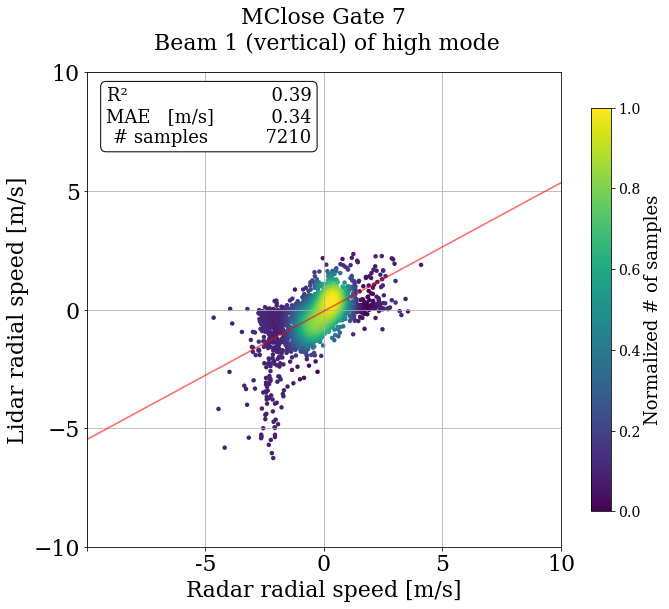

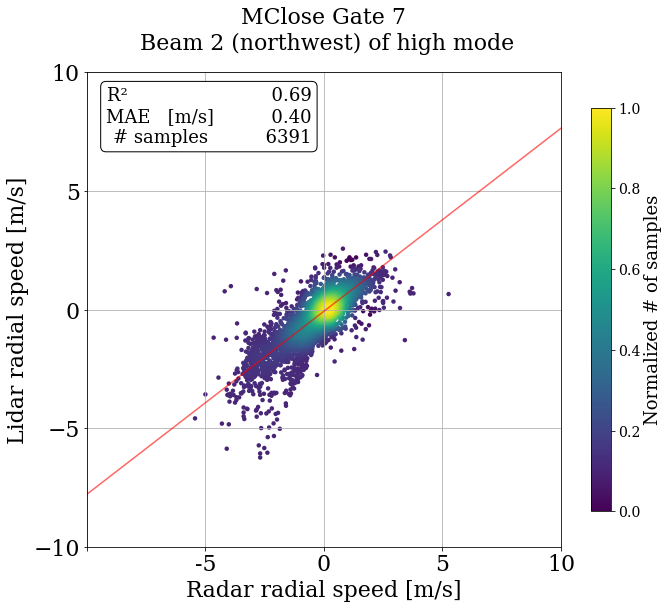

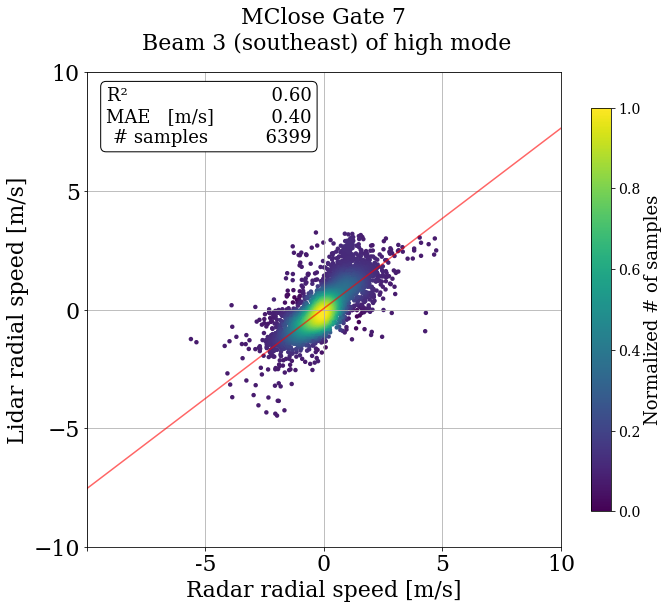

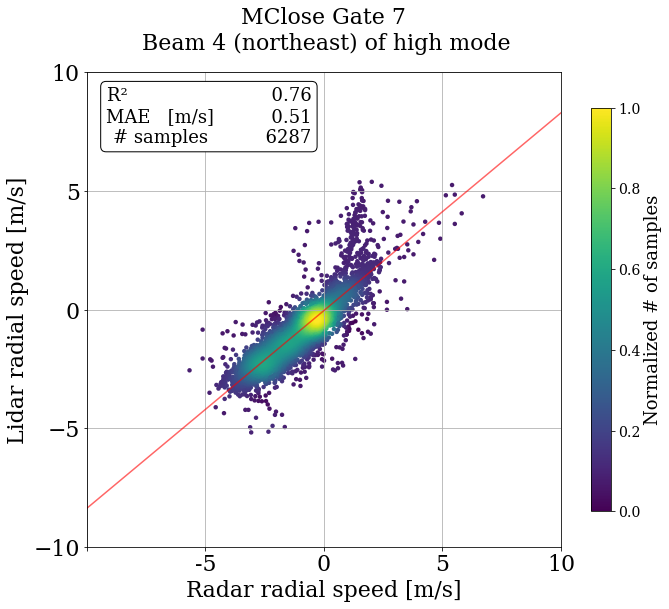

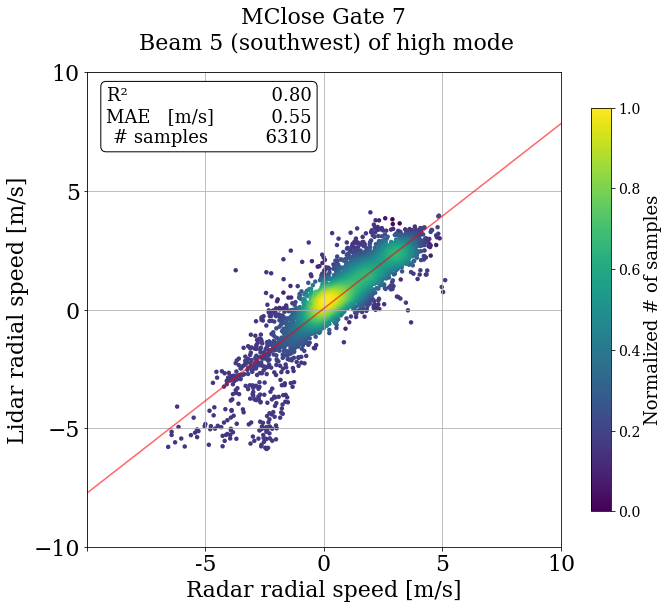

In [6]:
option='fast'

for beam_number in range(1,6): 
    
    x, y = reshapeList(xA[beam_number], yA[beam_number])
    Noise = np.array(list(itertools.chain(*zNoise[beam_number])))
    Sig = np.array(list(itertools.chain(*zSig[beam_number])))
    SNR = Sig/Noise
    
    x=f2vRadar(x)   
    #maskSNR=SNR>3
    #x=x[maskSNR];y=y[maskSNR]
    
    score1, coef1, inter1, sum1, mae1, std1, mask,slope,intercept,MAE, RMSE, SUM, SCORE= doRegression(x,y)
    x=x[mask];y=y[mask];

    if option == 'fast':
        data, x_e, y_e = np.histogram2d(x,y,bins=[12,12])
        z = scipy.interpolate.interpn((0.5*(x_e[1:]+x_e[:-1]), 0.5*(y_e[1:]+y_e[:-1])),
                                       data,np.vstack([x,y]).T, method="splinef2d", bounds_error=False)
    if option == 'best':
        xy = np.vstack([x,y])
        z = scipy.stats.gaussian_kde(xy)(xy)
    idx = z.argsort()
    x,y,z = x[idx],y[idx],z[idx]

    fig, ax = plt.subplots()
    xx = np.arange(-10, 11, 1)
    ax.plot(xx, slope*xx+intercept, 'red', alpha=0.6)
    ax.annotate("MClose Gate 7 \n{}".format(beam_radar_pretty[str(beam_number)]),
    xy=(240, 540), xycoords='axes points', #550
    size=fontsize1, ha='center', va='top')
    ax.annotate("R\u00b2 {: >28}\nMAE   [m/s]{: >14}\n# samples {: >13}".format(score1,mae1, sum1),
    xy=(225, 460), xycoords='axes points',
    size=fontsize1-4, ha='right', va='top',bbox=dict(boxstyle='round', fc='w'))

    cax=ax.scatter(x,y, c=z/100000, s=20, edgecolor='')
    ax.set_xlabel('Radar radial speed [m/s]', fontsize=fontsize1);
    ax.set_ylabel('Lidar radial speed [m/s]',fontsize=fontsize1);
    ax.grid()    
    plt.gca().set_aspect('equal')
    plt.gcf().set_size_inches(10,10)
    ax.set_xlim([-10, 10])
    ax.set_ylim([-10, 10])
    ax.set_yticks(np.arange(-10,11,5));
    ax.set_xticks(np.arange(-10,11,5));ax.set_xticklabels(['',-5,0,5,10])

    norm = matplotlib.colors.Normalize(0,1)
    cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm),ax=ax, shrink=0.65)
    cbar.ax.set_ylabel('Normalized # of samples', rotation=90, fontsize=fontsize1-4)
    cbar.ax.tick_params(labelsize=14)

    plt.tight_layout()
    plt.savefig(pathSave+'coherency_beam'+str(beam_number)+'MCloseGate7')

# Figures

In [7]:
with open(os.getcwd()+'/resultsCoherencyFixed.pickle', "rb") as f:
    results = pickle.load(f)
    
# Metrics order : MAE, RMSE, SUM, SCORE
# Scenarios order
# 0 ALL
# 1 CHOSING RIGHT MOMENT
# 2 Sun
# 3 Rain
# 4 Day
# 5 Night
# 6 SNR3
# 7 Best

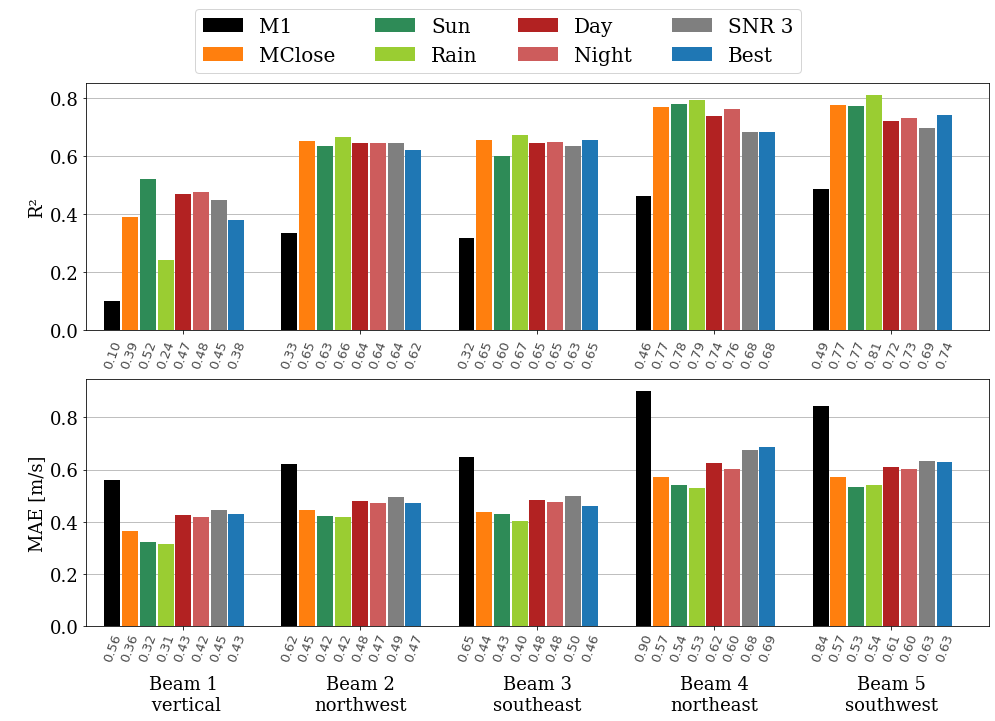

In [9]:
def autolabel(rects,ax,h,hh):    
    for indice, rect in enumerate(rects):
        ax.text(rect.get_x()+rect.get_width()/2,hh,'%.2f'%h,ha='center',va='bottom',
                fontsize=13,rotation=70,fontweight='roman',fontfamily='DejaVu Sans',alpha=0.7,
                fontstretch='semi-condensed')

def swapList(l):
    return l#l[0:2]+l[3:10] #+[l[2]]

matplotlib.rcParams.update({'font.size': fontsize1-4})
matplotlib.rcParams['figure.subplot.hspace'] = 0.2
fig, ax = plt.subplots(2,1);

offset= [-0.40,-0.30,-0.20,-0.10,0,0.10,0.20,0.30,0.40]
width=0.09
hh1=[-0.14]*8

colorList=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:grey','tab:blue']
colorList=['black','tab:orange','seagreen','yellowgreen','firebrick','indianred','tab:grey','tab:blue']

x = np.arange(1,6,1)
scenarios_name = swapList(['M1','MClose', 'Sun','Rain','Day','Night','SNR 3','Best', 'SNR .05',
                           'F','FGate', 'Gate 8'])
for beam_number in range(0,5):
    for scenarios in range(0,8):
        if beam_number==0:
            rect = ax[1].bar(x[beam_number]+offset[scenarios],[y[0] for y in swapList(results[beam_number+1])][scenarios],
                      align='center',width=width, label='{}'.format(scenarios_name[scenarios]),
                      color=colorList[scenarios]);
            autolabel(rect,ax[1],[y[0] for y in swapList(results[beam_number+1])][scenarios],hh1[scenarios])
        else:
            rect = ax[1].bar(x[beam_number]+offset[scenarios], [y[0] for y in swapList(results[beam_number+1])][scenarios],
                      align='center',width=width,color=colorList[scenarios]);
            autolabel(rect,ax[1],[y[0] for y in swapList(results[beam_number+1])][scenarios],hh1[scenarios])
        
        rect = ax[0].bar(x[beam_number]+offset[scenarios], [y[3] for y in swapList(results[beam_number+1])][scenarios],
                  align='center',width=width,color=colorList[scenarios]);
        autolabel(rect,ax[0],[y[3] for y in swapList(results[beam_number+1])][scenarios],hh1[scenarios])

ax[0].set_axisbelow(True); ax[0].grid(axis='y') 
ax[1].set_axisbelow(True); ax[1].grid(axis='y')  

ax[0].set_ylabel('\nR\u00b2'); ax[1].set_ylabel('MAE [m/s]'); 
ax[0].set_xticks(np.arange(1,6,1));plt.setp(ax[0].get_xticklabels(), visible=False);
ax[1].set_xticks(np.arange(1,6,1));
ax[0].set_xlim(0.45,5.55);ax[1].set_xlim(0.45,5.55);
ax[0].set_yticks([0,0.2,0.4,0.6,0.8])
ax[1].set_yticks([0,0.2,0.4,0.6,0.8])
ax[1].set_xticklabels(['\n\nBeam 1\n vertical','\n\nBeam 2\nnorthwest','\n\nBeam 3\nsoutheast', '\n\nBeam 4\nnortheast','\n\nBeam 5\nsouthwest'])

fig.legend(ncol=4, loc='upper center',fontsize=fontsize1-2);
plt.savefig(pathSave+'coherency_barplot1')

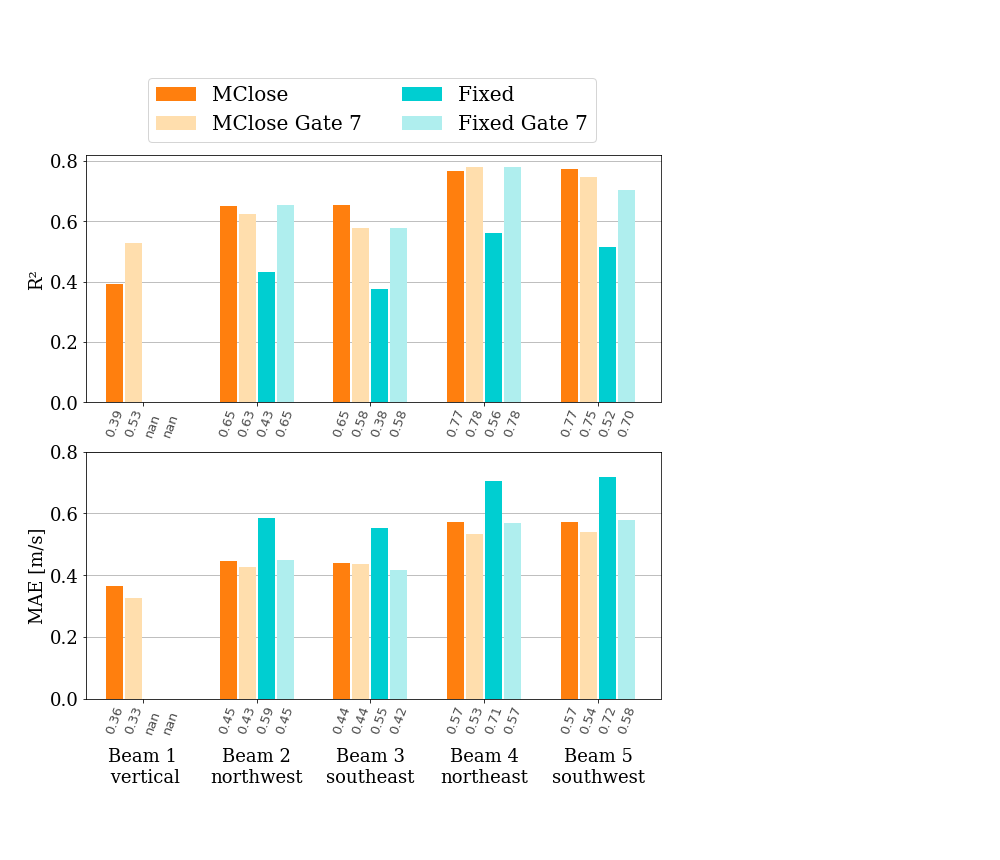

In [10]:
def swapList(l):
    return [l[1]]+[l[12]]+[l[10]]+[l[11]] #+[l[2]]

matplotlib.rcParams.update({'font.size': fontsize1-4})
matplotlib.rcParams['figure.subplot.hspace'] = 0.2
fig, ax = plt.subplots(2,1);

offset= [-0.15,-0.05,0.05,0.15]
width=0.09
hh1=[-0.12]*4

colorList=['tab:orange','navajowhite','darkturquoise','paleturquoise']

x = np.arange(1,6,1)
x = np.arange(1,4,0.6)
scenarios_name = swapList(['M1','MClose', 'Gate','Sun','Rain','Day','Night','SNR .01','SNR .03', 'SNR .05',
                           'Fixed ','Fixed Gate 7', 'MClose Gate 7'])
for beam_number in range(0,5):
    for scenarios in range(0,4):
        #if np.isnan(hh): 
        if beam_number==0:
            rect = ax[1].bar(x[beam_number]+offset[scenarios],[y[0] for y in swapList(results[beam_number+1])][scenarios],
                      align='center',width=width, label='{}'.format(scenarios_name[scenarios]),
                      color=colorList[scenarios]);
            autolabel(rect,ax[1],[y[0] for y in swapList(results[beam_number+1])][scenarios],hh1[scenarios])
        else:
            rect = ax[1].bar(x[beam_number]+offset[scenarios], [y[0] for y in swapList(results[beam_number+1])][scenarios],
                      align='center',width=width,color=colorList[scenarios]);
            autolabel(rect,ax[1],[y[0] for y in swapList(results[beam_number+1])][scenarios],hh1[scenarios])
        
        rect = ax[0].bar(x[beam_number]+offset[scenarios], [y[3] for y in swapList(results[beam_number+1])][scenarios],
                  align='center',width=width,color=colorList[scenarios]);
        autolabel(rect,ax[0],[y[3] for y in swapList(results[beam_number+1])][scenarios],hh1[scenarios])

ax[0].set_axisbelow(True); ax[0].grid(axis='y') 
ax[1].set_axisbelow(True); ax[1].grid(axis='y')  

ax[0].set_ylabel('\nR\u00b2'); ax[1].set_ylabel('MAE [m/s]'); 
ax[0].set_xticks(x);plt.setp(ax[0].get_xticklabels(), visible=False);
ax[1].set_xticks(x);

ax[0].set_xlim(0.7,5.46);ax[1].set_xlim(0.7,5.46);
ax[0].axvline(3.74, color='black');ax[1].axvline(3.74, color='black');
ax[0].set_yticks([0,0.2,0.4,0.6,0.8])
ax[1].set_yticks([0,0.2,0.4,0.6,0.8])
ax[1].set_xticklabels(['\n\nBeam 1\n vertical','\n\nBeam 2\nnorthwest','\n\nBeam 3\nsoutheast', '\n\nBeam 4\nnortheast','\n\nBeam 5\nsouthwest'])
 
string ='                                                         \n'
string2 = string+string+string+string+string+string+string+string+string+string+string+string+string+string+string+string+string+string+string
ax[0].annotate(string2,xy=(580, -150), xycoords='axes points',backgroundcolor='white') 
ax[1].annotate(string2,xy=(580, -150), xycoords='axes points',backgroundcolor='white') 

fig.legend(ncol=2,bbox_to_anchor=(-0.58,1.1,1.1,0),fontsize=fontsize1-2);
plt.savefig(pathSave+'coherency_barplot2')